# tutorial 5

Creating new units, synapses, and plants

## Part 1
### Creating a new type of unit

Suppose you want to create a unit that outputs the value $-1$ when the sum of its inputs is below a threshold $\theta$, and outputs $1$ otherwise.  
Because Draculab's units are continuous-time dynamical systems, the unit we'll create is not quite the same as a typical binary unit. Switching the output value from $-1$ to $1$ (and viceversa) will happen gradually, with a time constant $\tau$, and the unit will approach its end values asymptotically. If the $i$-th unit has output $x_i$, then its dynamics are described by:  
$ \dot{x_i} = 
\begin{cases}
-1/\tau \text{  if  } I > \theta , \\
1/\tau \text{  if  } I \leq \theta .
\end{cases} \\
\text{where } I = \sum_j \omega_{ij} x_j. $

Creating a new type of unit can be divided into 3 steps:

1. Register the name of the new unit in `draculab.py`.  
The unit class will be written into `custom_units.py`, where you:  
2. Add the `__init__` method.  
3. Add the `derivatives` (or `dt_fun`) method.

Tor register the name of a new unit type open the `draculab.py` and locate the `unit_types` class, which is an [enum](https://docs.python.org/3/library/enum.html).

In the `unit_type` class we define an attribute with the name of the unit, and assign it a unique integer value to identify it. In the case of our unit, we could call it "binary", and assign it the value 101.

Next, in the `unit_types.get_class` method we need to associate the name of the type (e.g. "binary") with the name of the class implementing it in `custom_units.py`. Once this is done we can create this type of units using `network.create(n, params_dict)`, where the paramters dictionary contains the entry `'type' = unit_types.binary`. In general it is better to have the type name and the name of the class being equal, but for the purpose of this tutorial, the class implementing binary units will be `binary_unit`.

In [ ]:
# The code to be entered in the unit_types class is thus
binary = 101
# among the other unit names, and
elif self == unit_types.binary:
    unit_class = binary_unit
# among the elif statements of the get_class method

Let's now write the class implementing the unit in `custom_units.py`.

In [ ]:
class binary_unit(unit):
    """ The unit type created in tutorial 5. """
    def __init__(self, ID, params, network):
        """ The unit constructor. 
        
        Args:
            ID, params, network: same as in the 'unit' parent class.
            In adittion, params should have the following entries.
            REQUIRED PARAMETERS
            tau: time constant for the update dynamics.
            theta: unit's threshold.
        """
        unit.__init__(self, ID, params, network) # parent's constructor
        self.tau = params['tau']
        self.theta = params['theta']
        
    def derivatives(self, y, t):
        """ Derivative function of the binary unit.
        
        Args:
            y: a 1-element array with the current firing rate.
            t: time when the derivative is evaluated.
        """
        I = self.get_input_sum(t)
        if I < self.theta:
            return (-1. - y[0])/self.tau
        else:
            return (1. - y[0])/self.tau
        
    def dt_fun(self, y, s):
        """ The derivative function used by flat networks.
        
        Args:
            y: a scalar value with the current firing rate.
            s: index used to retrieve the input sum to use.
        """
        I = self.inp_sum[s]
        if I < self.theta:
            return (-1. - y)/self.tau
        else:
            return (1. - y)/self.tau

After changing the source code, you neeed to reset the kernel of the Jupyter notebook and import draculab once more.  
Now the unit is ready to use!

Some comments about the class definition:
* The `__init__` method always begins with `unit.__init__(self, ID, params, network)`. This provides the new unit type with all the functionality of the `unit` class. For more information type `help(unit.__init__)`.
* the `derivatives` method is used by `unit.update`, whereas `unit.flat_update` calls `dt_fun`. It is not necessary to write both methods, but adding them both allows our unit to work in simulations with regular and flat networks.
* The `get_input_sum` method is a utility provided by the `unit` class. It returns the sum of all the inputs received by the unit at a given time, each input multiplied by its corresponding synaptic weight. Moreover, all the inputs are obtained considering their corresponding delays. Other methods provided by the unit class are `get_inputs`, and `get_weights`. These can be used to make the `derivatives` function easier to write and read.
* When the network is flat, the unit will have an `inp_sum` attribute, which provides the scaled sum of inputs at various points in time. `inp_sum[0]` is the input sum at the beginning of the current simulation step. `inp_sum[1]` is the input sum at `min_delay/min_buff_size` time units later, and so forth. Unless we're writing a new integration it is not necessary to understand these details. What's important is to know that `imp_sum[s]` is the input. If for some reason the "raw" inputs are required, these are in the `unit.step_inps` array (see `unit.upd_flat_inp_sum`).
* Unit types that use multiple input ports need to override `unit.get_mp_input_sum` in order to specify how to interpret the inputs that arrive at different ports. Such a thing is not part of this tutorial. 

/home/z/projects/draculab/network.py:840: UserWarning: Integration method odeint subsituted by Forward Euler in some units
  ' subsituted by Forward Euler in some units', UserWarning)


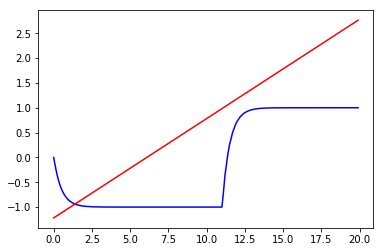

In [1]:
# A quick test of the unit
from draculab import *
from matplotlib import pyplot as plt

# create a network
net_params = { 'min_delay':.1, 'min_buff_size':10}
net = network(net_params)

# create a test unit and an input unit
test_unit_params = {'type': unit_types.binary, #### this is new
               'theta': 1.,
               'tau': 0.5,
               'init_val':0.}
input_unit_params = {'type': unit_types.source,
                     'init_val': -1.,
                     'function': lambda t: -1 + .2*t }
test_unit = net.create(1, test_unit_params)
input_unit = net.create(1, input_unit_params)

# connect them
conn_spec = {'rule': 'one_to_one',
             'delay': 1. }
syn_spec = {'type': synapse_types.static,
            'init_w': 1. }
net.connect(input_unit, test_unit, conn_spec, syn_spec)

# simulate
times, activs, _ = net.run(20.)
#times, activs, _ = net.flat_run(20.)

# plot
fig = plt.figure
plt.plot(times, activs[0], 'b', times, activs[1], 'r')
plt.show()

## Part 2
### Creating a new synapse type

Now let's assume that we want to create a new type of synapse. This synapse will have a weight that will adopt one of two values, -1 or 1 (clearly not biologically realistic). Let $\langle x_{pre} \rangle$ be the average value of the presynaptic activity, and $\langle x_{post} \rangle$ be the average postsynaptic activity. Our synapse will be such that the weigth will move to -1 if $\langle x_{pre} \rangle > \langle x_{post} \rangle$, and to 1 otherwise.

Before we proceed to write the synapse class, we should specify how the average activity is calculated. The average of a continuous function $f$ is usually defined as
$ \frac{1}{T} \int_{t_0}^{t_0 + T} f(s) ds $. Using this type of average for our rule, however, is not very practical; the reason is that it gives the same importance to values that occurred in the distant past compared to recent values. After a while, the values of the average become slower, and slower to respond.

A simple way to obtain an average that places more importance on the most recent values is to use a first order *low-pass filter*. A simple, yet effective version is defined by:
$\frac{d \langle x \rangle}{dt} = \frac{ x - \langle x \rangle }{ \tau_f } $.

Such a quantity can be calculated by the unit and made available to all its synapses if the unit contains a low-pass filter *requirement*. In general, a requirement can be added to a unit if the requirement's name is added to `syn_needs`, which is an object of the *set* data type in the unit. This can be done in the unit's constructor. The name of all available requirements can be seen in the `syn_reqs` enum class of `draculab.py`. Alternatively, they are displayed by the command `syn_reqs.list_names()`. Documentation about a particular requirement can be found in the methods of the `requirements.py`; in particular, in the methods called `add_<requirement name>`.

In the case of requirements used by synapses, it is not necessary to add them in the constructors of the units we'll use. If we specify which requirements will be used by the synapse in its constructor, these will be automatically added to the relevant units by `network.connect`. The code in this example will illustrate this.

Similarly to the case of units, to create the new synapse type we will follow 3 steps:
1. Register the name of the synapse in the synapse_types enum at `draculab.py`. This is basically the same as the first step to create a new unit type.
2. Create the synapse class, with an __init__ method.
3. Write the function that the synapse uses to update its weight in the `update` method.

Our new type of synapse will be called *switcher*, and so will its corresponding class.

In [3]:
# In draculab.py you need to write
switcher = 101
# in the synapse_types class, and
elif self == synapse_types.switcher:
        syn_class = switcher
# in the get_class method.

SyntaxError: invalid syntax (<ipython-input-3-7ed4d493a622>, line 4)

In [ ]:
class switcher(synapse):
    """ The synapse created in part 2 of tutorial 5. """
    def __init__(self, params, network):
        """ The class constructor. 
        
        Args:
            params: same as the 'synapse' parent class, with these additions
            'lrate': learning rate; a scalar that multiplies the weight's derivative
        """
        synapse.__init__(self, params, network) # calling the parent's constructor
        self.lrate = params['lrate'] # learning rate
        self.upd_requirements = set([syn_reqs.lpf_mid, pre_lpf_mid])
        self.alpha = self.lrate * self.net.min_delay # factor that scales the update rule 
        
    def update(self, time):
        """ Updates the synaptic weight at each simulation step. """
        pre_avg = self.net.units[self.preID].get_lpf_mid(self.delay_steps)
        post_avg = self.net.units[self.postID].get_lpf_mid(0)
        if pre_avg > post_avg:
            self.w += self.alpha * (-1. - self.w)
        else:
            self.w += self.alpha * (1. - self.w)